# Agent Learning Project

## Imports 

We start by importing the required libaries. Uncomment & run the next cell in case some of the libraries aren't installed in your environment. 

In [1]:
# !pip install numpy matplotlib tqdm

In [2]:
import numpy as np # Computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
from collections import defaultdict # Dictionary that sets a default value for any key
from tqdm import tqdm # Progress bar

## Defining the Agent class

We define a type of agent with the following attributes: 
- Agent name : Name of the agent
- Service probability : If at the counter, shows the probability that this agent will be serviced.
- Reward : Reward the counter gets for servicing this agent
- Time in queue : Time for which the agent has been in the queue. 

In [3]:
class Agent:
    def __init__(self, name):
        self.name = name
        self.service_prob, self.reward, self.penalty = agents[name][:3]
        self.penalty_function = agents[name][4]
        self.time_in_queue = 0

    def __eq__(self, other):
        if self is None or other is None: 
            return False
        return self.name == other.name

    def __str__(self):
        return f"Agent {self.name} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [4]:
class QueueSimulation:
    def __init__(self, agents, QAgent, arrival_prob=0, init=0, alpha=0, discount=1, truncation=20):
        # Define the agents, their distribution, and the strategy
        self.agents = agents
        self.agent_distribution = np.array([agent[3] for agent in agents.values()])
        self.agent_distribution = self.agent_distribution / np.sum(self.agent_distribution)

        # Defining the QAgent
        self.QAgent = QAgent 
        
        # Define the hyper-parameters of the simulation
        self.arrival_prob, self.init, self.alpha, self.discount = arrival_prob, init, alpha, discount
        self.fixed_discount, self.discount = discount, 1 # Optimization trick to avoid recomputing power at each step
        
        # Define the Queue
        self.queue = [self.create_agent() for _ in range(init)] if type(init) == int else init
        self.current_agent = None if len(self.queue) == 0 else self.queue.pop(0)
        self.truncation = truncation
        
        # Variables that are used to analyze our code
        self.time, self.busy, self.total_reward, self.discounted_reward = 0, 0, 0, 0
        
        # Tracking the history for graphs
        self.serviced_agents = defaultdict(int)
        self.reward_history, self.queue_length_history = [], []

    def create_agent(self):
        name = np.random.choice(list(self.agents.keys()), p=self.agent_distribution)
        return Agent(name)

    def train_step(self):
        """
        This function is the core of the simulation. It defines what happens at every step. The order in which 
        the computations are made is important so we have to be careful. In our case, we proceed as follows:
        
        1. Determine whether an agent is joining the queue
        2. Detemine if the agent in service is going to complete service or not and potentially add reward 
        3. Add penalty to the reward
        4. Apply the given strategy to determine what happens next
        5. Add the information related to the step to the simulation history
        
        Please feel free to ask for any changes in the implementation
        """
        self.time += 1 # Update time
        self.discount *= self.fixed_discount # Update Discount
        reward_this_step, agent_this_step = 0, self.current_agent
        state_this_step = self.QAgent.get_state(self.queue, self.agents, self.current_agent) 
        
        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                reward_this_step += self.current_agent.reward
                self.total_reward += self.current_agent.reward
                self.discounted_reward += self.current_agent.reward*self.discount
                self.serviced_agents[self.current_agent.name] += 1
                self.current_agent = None
        
        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            agent_count = sum(1 for agent in self.queue if agent.name == new_agent.name)
            if agent_count < self.truncation:
                # If there is too much of this agent in the queue, we reject the new entry
                self.queue.append(new_agent)
        
        # Apply penalty on reward
        for agent in self.queue: 
            agent.time_in_queue += 1
            reward_this_step -= agent.penalty_function(self.time, agent.penalty)
            self.total_reward -= agent.penalty_function(self.time, agent.penalty)
            self.discounted_reward -= agent.penalty_function(self.time, agent.penalty*self.discount)

        length = len(self.queue)
        reg_penalty = regularization(self.alpha, length)
        reward_this_step -= reg_penalty
        self.total_reward -= reg_penalty
        self.discounted_reward -= reg_penalty*self.discount

        # Apply the strategy to select the next agent
        if self.queue:
            self.q_learning_strategy(state_this_step, reward_this_step, agent_this_step)
        
        # Add the step's information to the simulation history
        length = len(self.queue)
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(length)
        self.busy += bool(self.current_agent)

    def test_step(self, test_queue=[], test_arrival_prob=0, verbose=False):
        """
        This function is similar to the above training function but is thought to test what actions are taken on
        a given queue after training. We allow it to have different parameters than the ones used for training.
        """   
        self.time += 1 # Update time
        self.discount *= self.fixed_discount # Update Discount
        
        # Add new agent to the queue based on arrival probability
        if np.random.rand() < test_arrival_prob:
            new_agent = self.create_agent()
            agent_count = sum(1 for agent in self.queue if agent.name == new_agent.name)
            if agent_count < self.truncation:
                # If there is too much of this agent in the queue, we reject the new entry
                self.queue.append(new_agent)
                
        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                self.total_reward += self.current_agent.reward
                self.discounted_reward += self.current_agent.reward*self.discount
                self.serviced_agents[self.current_agent.name] += 1
                self.current_agent = None

        # Apply penalty on reward
        for agent in self.queue: 
            agent.time_in_queue += 1
            self.total_reward -= agent.penalty_function(self.time, agent.penalty)
            self.discounted_reward -= agent.penalty_function(self.time, agent.penalty*self.discount)

        length = len(self.queue)
        reg_penalty = regularization(self.alpha, length)
        self.total_reward -= reg_penalty
        self.discounted_reward -= reg_penalty*self.discount

        # Apply the strategy to select the next agent
        if self.queue:
            self.q_learning_strategy(verbose=verbose, test=True)
        
        # Add the step's information to the simulation history
        length = len(self.queue)
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(length)
        self.busy += bool(self.current_agent)

    def q_learning_strategy(self, prev_state=None, reward=0, agent=None, verbose=False, test=False):
        state = self.QAgent.get_state(self.queue, self.agents, self.current_agent) 
        action_name = self.QAgent.choose_action(state, self.queue, self.current_agent, verbose)
        if action_name is None or (self.current_agent and self.current_agent.name == action_name):
            # Nothing should be done
            pass
        else:
            action_index = next(i for i, agent in enumerate(self.queue) if agent.name == action_name)
            if self.current_agent:
                self.queue[action_index] = self.current_agent
                self.current_agent = Agent(action_name)
            else:
                self.current_agent = self.queue.pop(action_index)
        if not test:
            # Observe the next state
            next_state = self.QAgent.get_state(self.queue, self.agents, self.current_agent)
            
            # Update the Q-table
            if prev_state is not None and agent is not None:
                self.QAgent.update_q_table(prev_state, agent.name, reward, next_state)

    def train(self, steps=10_000, dynamic=False):
        bar_format = (
            "{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} "
            "[{rate_fmt}] [{elapsed}<{remaining}]")
        if not dynamic:
            for _ in tqdm(range(steps), desc="Training Agent", bar_format=bar_format):
                self.train_step()
        else:
            truncation = self.truncation
            for i in tqdm(range(steps), desc="Training Agent", bar_format=bar_format):
                self.truncation = int(truncation * i**0.5 / steps**0.5) + 1
                self.train_step()
            self.truncation = truncation

    def test(self,test_queue=[], test_arrival_prob=0, verbose=False):
        # Resetting variables for testing
        memory = [self.queue, self.time, self.busy, self.total_reward, self.discounted_reward, \
                       self.serviced_agents, self.reward_history, self.queue_length_history]
        self.queue = test_queue
        self.time, self.busy, self.total_reward, self.discounted_reward = 0,0,0,0
        self.serviced_agents = defaultdict(int)
        self.reward_history, self.queue_length_history = [], []
        self.QAgent.set_test_mode()

        # Testing
        for _ in tqdm(range(testing_steps), desc="Testing Agent"):
            self.test_step(test_queue, test_arrival_prob, verbose)
        self.get_results()

        # Restauring variables
        self.queue, self.time, self.busy, self.total_reward, self.discounted_reward, \
        self.serviced_agents, self.reward_history, self.queue_length_history = memory
        self.QAgent.set_train_mode()

    def get_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()
        
        self.min_queue_length = np.min(self.queue_length_history)
        self.max_queue_length = np.max(self.queue_length_history)
        self.mean_queue_length = np.mean(self.queue_length_history)
        self.normalized_distribution = {agent_type: round(count / sum(self.serviced_agents.values()), 3) for agent_type, count in sorted(self.serviced_agents.items(), key=lambda item: item[1], reverse=True)}
        
        print(f"\nTotal reward: {self.total_reward}")
        print(f"Discounted reward: {self.discounted_reward}")
        print(f"Average reward per step: {self.total_reward/self.time}")
        print(f"Min & Max Queue Length: {self.min_queue_length} & {self.max_queue_length}")
        print(f"Mean Queue Length: {self.mean_queue_length}")
        print(f"Normalized Distribution of Serviced Agents: {self.normalized_distribution}")
        print(f"Time spent busy: {self.busy/self.time}")
        print(f"--------------------------------------------------------")


In [5]:
# Compute average service probability
def service():
    service_prob = np.array([agent[0] for agent in agents.values()])
    weights = np.array([agent[3] for agent in agents.values()])
    distribution = weights / np.sum(weights)
    x = np.dot(service_prob, distribution.T)
    if x == 0:
        return 0, float('inf')
    return x,1/x

# Compute expected reward per agent
def average():
    probabilities = np.array([agent[0] for agent in agents.values()])
    rewards = np.array([agent[1] for agent in agents.values()])
    penalties = np.array([agent[2] for agent in agents.values()])
    average_values = {agent: rewards[i]*probabilities[i] - penalties[i]/probabilities[i] for i, agent in enumerate(agents.keys())}
    return average_values

# Create the initial list
def create(l, shuffle=False):
    queue = []
    for name, quantity in l:
        try:
            queue += [Agent(name)] * quantity
        except KeyError:
            print(f"Error: {name} is not a valid Agent name ! Moving on to the next Agent creation...")
            continue
    if shuffle:
        np.random.shuffle(queue)
    return queue

## Defining the Q-Learning Agent

In [6]:
class QLearningAgent:
    def __init__(self, agents, truncation, discount, learning_rate, epsilon, epsilon_function):
        self.agents, self.truncation = agents, truncation
        self.discount, self.learning_rate, self.epsilon = discount, learning_rate, epsilon
        self.epsilon_function, self.epsilon_memory = epsilon_function, epsilon
        self.q_table = defaultdict(lambda: {agent:0 for agent in agents.keys()})
        self.valid_actions={}

    def get_state(self, queue, agents, current_agent=None):
        state = {agent: 0 for agent in list(agents.keys())}
        if current_agent:
            state[current_agent.name] += 1
        for i, agent in enumerate(queue):
            if min(state.values()) >= self.truncation: break
            if state[agent.name] >= self.truncation: continue
            state[agent.name] += 1
        return tuple(state.items())

    def choose_action(self, state, queue, current_agent=None, verbose=False):
        valid_actions = {agent.name for agent in queue}
        if current_agent: valid_actions.add(current_agent.name)
        self.valid_actions = valid_actions
        if not valid_actions: return None
        if np.random.rand() < self.epsilon:
            self.epsilon = self.epsilon_function(self.epsilon)
            action = np.random.choice(list(valid_actions))
            if verbose:
                print(f"Exploration - Action: {action}")
            return action
        self.epsilon = self.epsilon_function(self.epsilon)
        state_values = {action: self.q_table[state][action] for action in list(valid_actions)}
        action = max(state_values, key=state_values.get)
        if verbose:
            print(f"Exploitation - Action: {action} ") 
        return action

    def update_q_table(self, state, action, reward, next_state):
        next_state_values = self.q_table[next_state]
        best_next_action = max(next_state_values, key=next_state_values.get)
        td_target = reward + self.discount * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def set_test_mode(self):
        self.epsilon_memory = self.epsilon
        self.epsilon = 0

    def set_train_mode(self):
        self.epsilon = self.epsilon_memory

## Choosing base parameters

In [7]:
training_steps = 1_000_000

# Penalty functions
def penalty_func_constant(time_in_queue, penalty_value):
    return penalty_value
    
def penalty_func_linear(time_in_queue, penalty_value):
    return penalty_value * time_in_queue

# Defining Agents
agents = {
    ### Agent name : [service_probability, reward, penalty, distrib_weight]
    # service_probability: float in [0,1]
    # reward, penalty, distrib_weight: float (unconstrained)
    "Alex" : [0.25, 100, 0, 3, penalty_func_constant], 
    "Ben" : [0.125, 10, 0, 3, penalty_func_constant],
    # "Cameron" : [0.3, 30, 0, 0, penalty_func_constant],
    # "Dennis" : [0.4, 20, 0, 0, penalty_func_constant],
    "Eric": [0.375, 30, 0, 3, penalty_func_constant],
    # "Fabien": [0.3, 50, 0, 0, penalty_func_constant],
}

# Probabilty that a new agent joins the queue
arrival_prob = 1

# Number of agents in the queue at t = 0
# We either choose a random weighted queue or a specific queue
start = 0
queue = create([("Ben", 1)], False) # [(name, quantity),(name, quantity),...], shuffle=True/False 
init = start # Choose a mode here

# Choose a discount factor for discounted reward computation
discount = 0.5

# Regularization parameter and function
alpha = 0.00
def regularization(alpha,length):
    return alpha*length

# Initialize Q-Learning Agent
truncation = 20
learning_rate = 0.01
epsilon = 0.2

# Epsilon decaying function
def epsilon_function(epsilon):
    return epsilon
    # return max(epsilon - 1/training_steps, 0.1)

## Training the Q-Learning model

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



Expected service probability & time across agents: (0.25, 4.0)
Expected reward + weighted penalty for each agent: {'Alex': 25.0, 'Ben': 1.25, 'Eric': 11.25}


Training Agent: 100%|█████████████████████████████████████| 1000000/1000000 [14691.78it/s] [01:08<00:00]


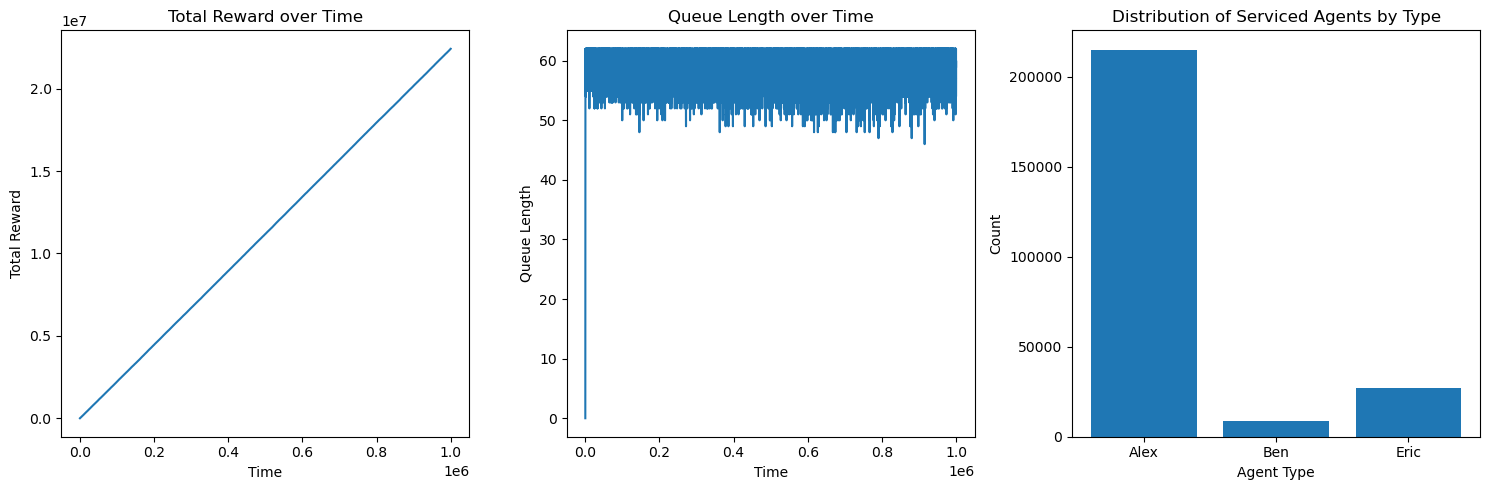


Total reward: 22414560.0
Discounted reward: 3.7109525903376017
Average reward per step: 22.41456
Min & Max Queue Length: 0 & 62
Mean Queue Length: 59.497924
Normalized Distribution of Serviced Agents: {'Alex': 0.858, 'Eric': 0.108, 'Ben': 0.034}
Time spent busy: 1.0
--------------------------------------------------------


In [8]:
QAgent = QLearningAgent(agents, truncation, discount, learning_rate, epsilon, epsilon_function)
simulation = QueueSimulation(agents, QAgent, arrival_prob, init, alpha, discount, truncation)

print(f"Expected service probability & time across agents: {service()}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
simulation.train(steps=training_steps)
simulation.get_results()

In [9]:
QAgent.q_table

defaultdict(<function __main__.QLearningAgent.__init__.<locals>.<lambda>()>,
            {(('Alex', 0), ('Ben', 0), ('Eric', 1)): {'Alex': 0,
              'Ben': 0,
              'Eric': 0.0},
             (('Alex', 1), ('Ben', 0), ('Eric', 1)): {'Alex': 0,
              'Ben': 0,
              'Eric': 0.0},
             (('Alex', 2), ('Ben', 0), ('Eric', 1)): {'Alex': 0.0,
              'Ben': 0,
              'Eric': 0},
             (('Alex', 3), ('Ben', 0), ('Eric', 1)): {'Alex': 1.0,
              'Ben': 0,
              'Eric': 0},
             (('Alex', 2), ('Ben', 1), ('Eric', 1)): {'Alex': 0.0,
              'Ben': 0,
              'Eric': 0},
             (('Alex', 2), ('Ben', 1), ('Eric', 2)): {'Alex': 0.0,
              'Ben': 0,
              'Eric': 0},
             (('Alex', 3), ('Ben', 1), ('Eric', 2)): {'Alex': 1.995,
              'Ben': 0,
              'Eric': 0.0},
             (('Alex', 3), ('Ben', 1), ('Eric', 3)): {'Alex': 0.0,
              'Ben': 0,
         

## Testing the Agent

### Defining the test variables

In [10]:
testing_steps = 1000
test_queue = create([("Alex",20),("Eric",20),("Ben",20)], shuffle=True)

### Displaying actions

Testing Agent: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 212037.01it/s]

Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation -

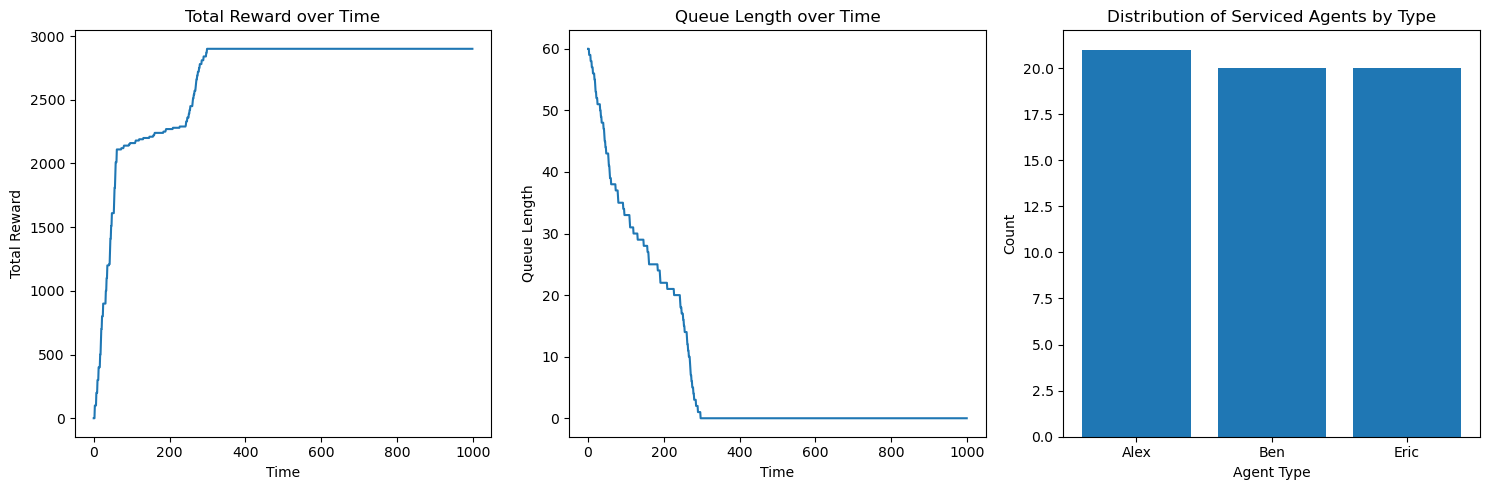


Total reward: 2900.0
Discounted reward: 0.0
Average reward per step: 2.9
Min & Max Queue Length: 0 & 60
Mean Queue Length: 8.598
Normalized Distribution of Serviced Agents: {'Alex': 0.344, 'Ben': 0.328, 'Eric': 0.328}
Time spent busy: 0.299
--------------------------------------------------------


In [11]:
simulation.test(test_queue=test_queue, test_arrival_prob=0, verbose=True)

## Improving training to cover more of the state space

Currently, we have a model which stays around the edges of the state space (truncation limit/zero). This is not optimal as in testing, we must also have some data in intermediate states in order to take the best decisions there, especially in cases where the reward/penalty of agents is dependent on time and that the optimal policy is not a priority list. Nonetheless, we still want to keep the benefits of Q-Learning which allows us to not have to explore all of the state space. 

We can therefore find a compromise by adding a ```dynamic``` flag to our training which will dynamically vary our ```truncation``` value (with a square root factor to emphasize the critical state space which will be our stability point in the simulation). We can then rerun our simulation taking that into account to get another training output and a more complete Q table.

Expected service probability & time across agents: (0.25, 4.0)
Expected reward + weighted penalty for each agent: {'Alex': 25.0, 'Ben': 1.25, 'Eric': 11.25}


Training Agent: 100%|█████████████████████████████████████| 1000000/1000000 [18471.03it/s] [00:54<00:00]


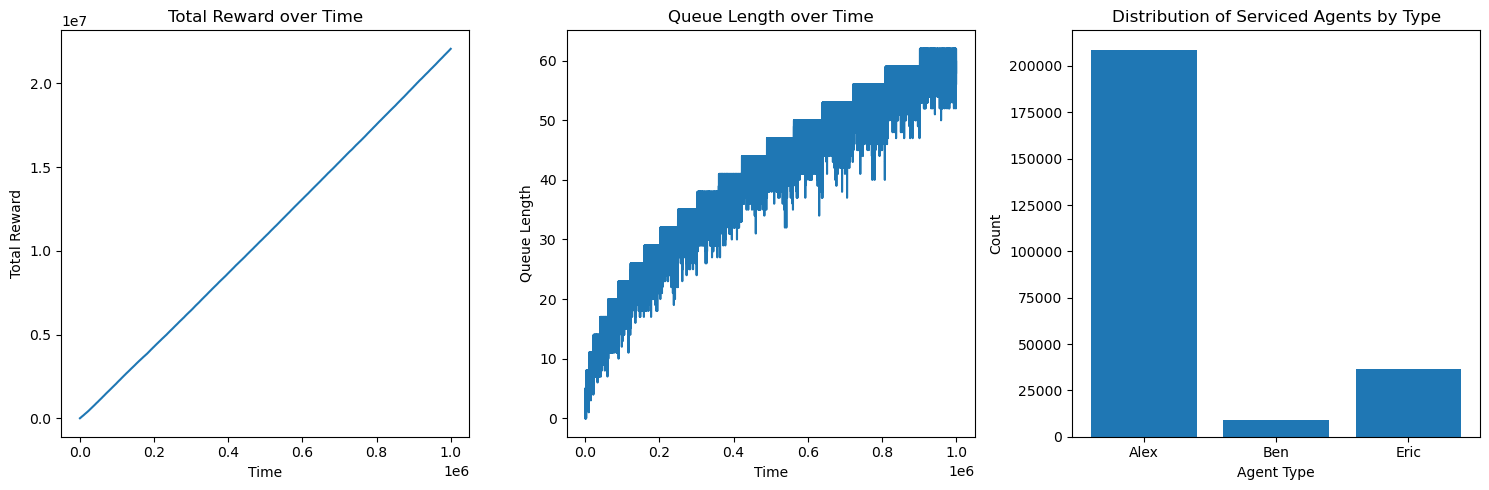


Total reward: 22071350.0
Discounted reward: 1.6115821992485024
Average reward per step: 22.07135
Min & Max Queue Length: 0 & 62
Mean Queue Length: 41.070242
Normalized Distribution of Serviced Agents: {'Alex': 0.821, 'Eric': 0.145, 'Ben': 0.035}
Time spent busy: 1.0
--------------------------------------------------------


In [12]:
dynamic_QAgent = QLearningAgent(agents, truncation, discount, learning_rate, epsilon, epsilon_function)
dynamic_simulation = QueueSimulation(agents, dynamic_QAgent, arrival_prob,init,alpha,discount,truncation)

print(f"Expected service probability & time across agents: {service()}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
dynamic_simulation.train(steps=training_steps, dynamic=True)
dynamic_simulation.get_results()

### Testing the Dynamic Agent

Testing Agent: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 222026.57it/s]

Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation - Action: Alex 
Exploitation -

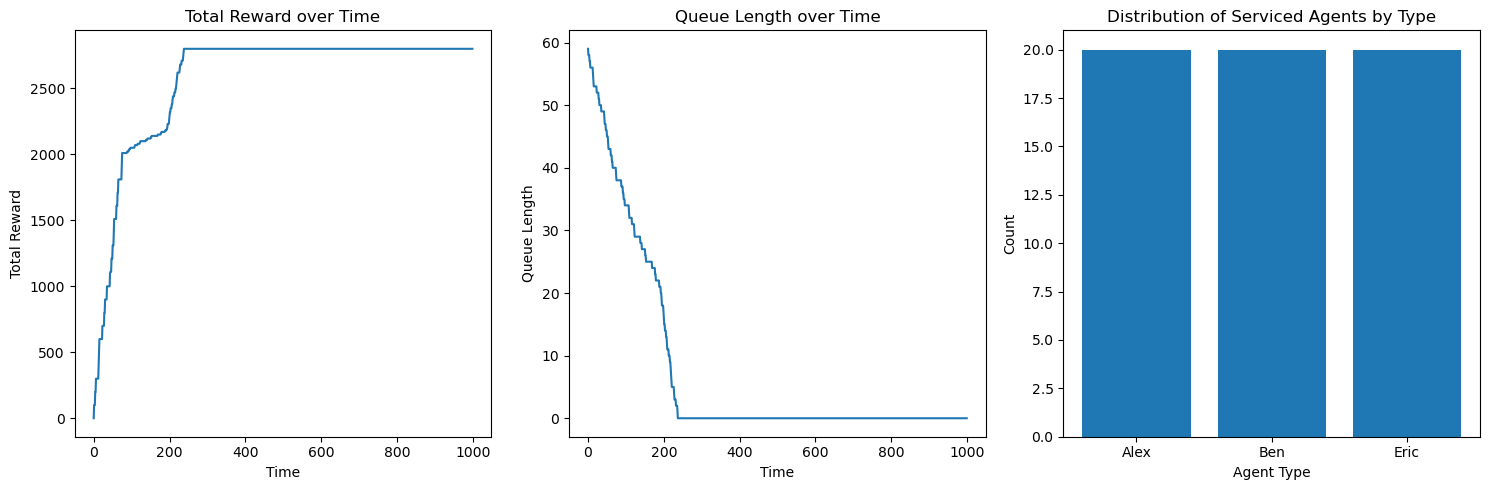


Total reward: 2800.0
Discounted reward: 0.0
Average reward per step: 2.8
Min & Max Queue Length: 0 & 59
Mean Queue Length: 7.517
Normalized Distribution of Serviced Agents: {'Alex': 0.333, 'Ben': 0.333, 'Eric': 0.333}
Time spent busy: 0.238
--------------------------------------------------------


In [13]:
testing_steps = 1000
test_queue = create([("Alex",20),("Eric",20),("Ben",20)], shuffle=True)
simulation.test(test_queue=test_queue, test_arrival_prob=0, verbose=True)

## Naïvely converting the Q-table to a priority list

We know that in states where the agents' penatly/reward is not dependent on time, the optimal policy is a priority list. From the Q table on which our model was trained, we can therefore tried to get the optimal policy by converting it to a priority list. This is done by doing the naive sum of all values in the Q table and sorting them in order to distinguish the agents that bring the most value/least penalty. 

You should therefore note that if the parameters of the simulation are such that the agents' penatly/reward to be dependent on time, we cannot expect of this algorithm to extract the optimal policy. 

In [14]:
naive_sum = defaultdict(float)

# Compute naive sum and max value for each agent
for state, values in dynamic_QAgent.q_table.items():
    for agent, value in values.items():
        naive_sum[agent] += value

priority_list = sorted(naive_sum.keys(), key=lambda agent: naive_sum[agent], reverse=True)
priority_list

['Alex', 'Eric', 'Ben']

From this output, you can then go to the ```QueueSimulation.ipynb``` file and feed the priority list as a strategy to analyze the outcome of the simulation.

# Comments

- I still have a truncation error bug. I do not see the root cause of it but I am investigating. It sometimes virutally increases the truncation limit and therefore allows for 62 agents in the queue (with 3 agents and a truncation of 20) instead of 61 (20*3 + the current agent). I do not know if this is a length computation mistake somewhere (which would be harmless), or an actual bug in the logic. I will add more details and fix this issue as soon as I can.

In case something needs to be changed, please feel free to write something in the cell below and email me about it. 